# BCEWithLogitsLoss

In [22]:
logits = torch.tensor([0.5, -1.2, 3.0], dtype=torch.float32)
labels = torch.tensor([1.0, 0.0, 1.0], dtype=torch.float32)

epsilon = 1e-15
probabilities = 1 / (1 + torch.exp(-logits))  # Sigmoid 激活
loss_per_sample = - (labels * torch.log(probabilities + epsilon) +
                     (1 - labels) * torch.log(1 - probabilities + epsilon))
loss = loss_per_sample.mean()  # 求平均损失
print(f"Manual Loss: {loss}")

criterion = torch.nn.BCEWithLogitsLoss()
loss = criterion(logits, labels)
print(f"Batch Loss: {loss.item()}")

Manual Loss: 0.2619822323322296
Batch Loss: 0.2619822323322296


In [1]:
from datasets import load_dataset
import numpy as np
import torch
from tqdm import tqdm

def get_data():
    dataset = load_dataset(path="D:\study\gen.1.celeba", split='train')
    dataset = dataset.shuffle(0).select(range(2000))
    import numpy as np
    def f(data):
        images = data['image']
        data = []
        for i in images:
            i = i.resize((64,64))
            i = np.array(i)
            i = (i-127.5)/127.5
            i = i.transpose(2,0,1)
            data.append(i)
        return {"image": data}
    dataset = dataset.map(function=f, batched=True, batch_size=1000, num_proc=10, remove_columns=list(dataset.features)[1:])
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in tqdm(range(len(dataset))):
        data[i] = dataset[i]['image']
    return data
    
dataset = get_data()
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=64, shuffle=True, drop_last=True)

D:\anaconda\envs\torch-1.13.1-py-3.8\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 149.82it/s]


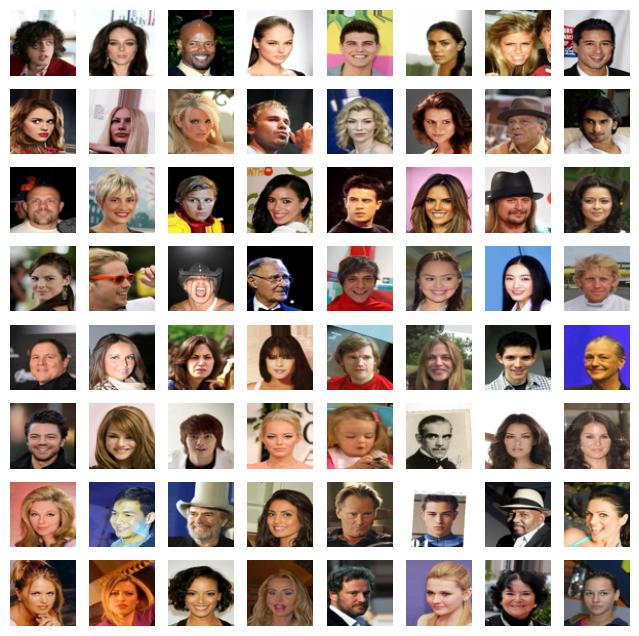

In [2]:
from matplotlib import pyplot as plt
def show(images):
    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()
    plt.figure(figsize=(8, 8))
    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1)/2
        plt.subplot(8, 8, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
show(next(iter(loader)))

In [3]:
class Block(torch.nn.Module):
    def __init__(self, dim_in, dim_out, is_encoder=True):
        super().__init__()
        cnn_type = torch.nn.Conv2d
        if not is_encoder:
            cnn_type = torch.nn.ConvTranspose2d
        def block(dim_in, dim_out, kernel_size=3, stride=1, padding=1):
            return (
                cnn_type(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding),
                torch.nn.BatchNorm2d(dim_out),
                torch.nn.LeakyReLU()
            )
        self.s = torch.nn.Sequential(
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_in),
            *block(dim_in, dim_out, kernel_size=3, stride=2, padding=0),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
            *block(dim_out, dim_out),
        )
        self.res = cnn_type(dim_in, dim_out, kernel_size=3, stride=2, padding=0)
        
    def forward(self, x):
        return self.s(x) + self.res(x)
        
Block(32, 3, False)(torch.randn(2, 32, 39, 39)).shape

torch.Size([2, 3, 79, 79])

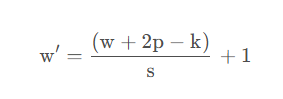

In [5]:
encoder = torch.nn.Sequential(
    Block(3, 32, True),  # b, 32, 31, 31
    Block(32, 64, True), # b, 64, 15, 15 
    Block(64, 128, True),  # b, 128, 7, 7
    Block(128, 256, True),  # b, 256, 3, 3
    torch.nn.Flatten(),  # b, 2304
    torch.nn.Linear(2304, 128)  # b, 128
)

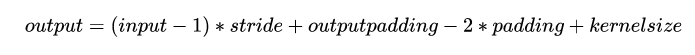

In [7]:
decoder = torch.nn.Sequential(
    torch.nn.Linear(128, 256*4*4),
    torch.nn.InstanceNorm1d(256*4*4),
    torch.nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
    Block(256, 128, False),  # b, 128, 9, 9
    Block(128, 64, False),  # b, 64, 19, 19
    Block(64, 32, False),   # b, 32, 39, 39
    Block(32, 3, False),   # b, 3, 79, 79
    torch.nn.UpsamplingNearest2d(size=64),  # b, 3, 64, 64
    torch.nn.Conv2d(3, 3, kernel_size=1, stride=1, padding=0),   # b, 3, 64, 64
    torch.nn.Tanh()
)

In [8]:
class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.fc_mu  = torch.nn.Linear(128, 128)   
        self.fc_log_var = torch.nn.Linear(128, 128)  

    def forward(self, data):
        hidden = self.encoder(data)  # [B, 128]
        mu = self.fc_mu(hidden)  # [B, 128]   潜在空间的均值，表示输入数据的潜在表示的均值。
        log_var = self.fc_log_var(hidden)  # [B, 128]   潜在空间的对数方差，表示输入数据的潜在表示的方差的对数。
        randn = torch.randn(mu.shape, device=hidden.device)  # [B, 128]
        hidden = mu + (log_var / 2).exp() * randn  # [B, 128] z=μ+σ⊙ϵ
        return self.decoder(hidden), mu, log_var  # [b, 3, 64, 64], [b,128], [b,128]

vae = VAE(encoder, decoder)
pred, mu, log_var = vae(torch.randn(2,3,64,64))
pred.shape, mu.shape, log_var.shape

(torch.Size([2, 3, 64, 64]), torch.Size([2, 128]), torch.Size([2, 128]))

In [9]:
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0, total_iters=1000 * len(loader))
criterion = torch.nn.MSELoss(reduction='none')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae.to(device)
vae.train()

VAE(
  (encoder): Sequential(
    (0): Block(
      (s): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01)
        (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): LeakyReLU(negative_slope=0.01)
        (9): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
        (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): LeakyReLU(negative_slope=0.01)
        (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13



### 数学原理

VAE的训练目标是最小化以下损失函数：

$$[ \mathcal{L} = \mathcal{L}_{\text{recon}} + \mathcal{L}_{\text{KL}} ]$$

其中，前者 是重构损失，后者是KL散度损失。

1. **重构损失**：
   - 通常使用均方误差（MSE）或二元交叉熵（BCE）来计算。
   - 在这个例子中，使用的是MSE，计算公式为：
     $$ [ \mathcal{L}_{\text{recon}} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2 ] $$
     其中，$$(x_i)$$ 是原始数据，$$(\hat{x}_i)$$ 是重建数据，$$(n)$$ 是数据点的数量。

2. **KL散度损失**：
   - KL散度衡量了两个分布之间的差异，在VAE中，它用于衡量潜在空间的分布与标准正态分布之间的差异。
   - 计算公式为：
     $$[ \mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{i=1}^{n} (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2) ]$$
     其中，$$(\mu_i)$$ 是潜在空间的均值，$$(\sigma_i^2)$$ 是潜在空间的方差。

通过最小化这个损失函数，VAE可以学习到输入数据的潜在表示，并生成新的数据。


0 3731.125 0.00019979999999999992


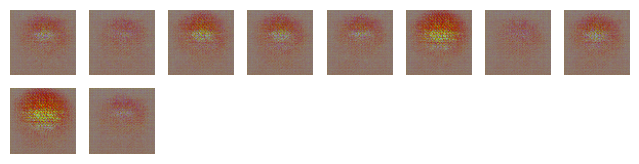

50 558.5858154296875 0.00018979999999999567


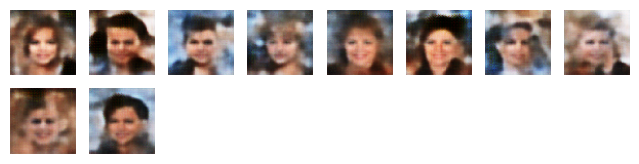

100 442.4331970214844 0.00017979999999999136


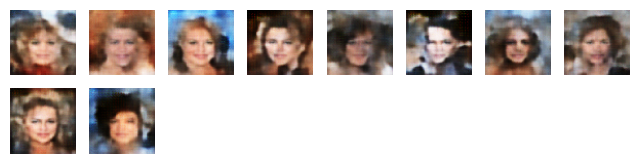

150 341.93377685546875 0.00016979999999998705


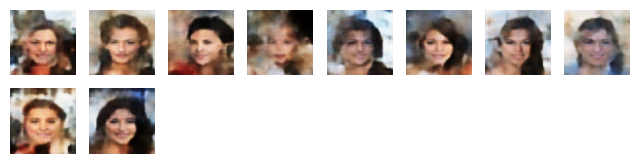

200 296.8089904785156 0.00015979999999998274


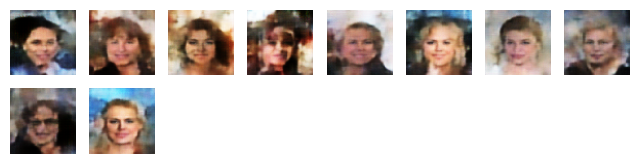

250 258.66363525390625 0.00014979999999997843


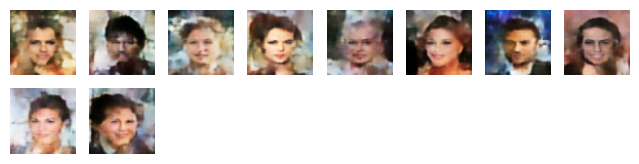

300 236.86911010742188 0.00013979999999997412


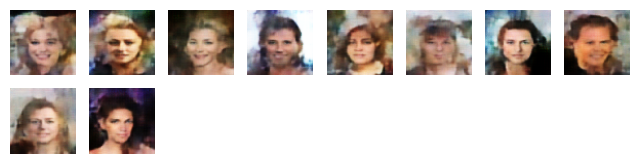

In [ ]:
def train():
    for epoch in range(1000):
        for _,data in enumerate(loader):
            data = data.to(device)
            pred, mu, log_var = vae(data)
            loss = criterion(pred, data) * 10000   # [64, 3, 64, 64] 
            loss = loss.mean(dim=(1,2,3))  # [64]  其中每个元素是对应样本的平均损失
            
            loss_kl = 1 + log_var - mu**2 - log_var.exp()  # [64, 128]
            loss_kl = loss_kl.sum(dim=1) * -0.5  # [64]  其中每个元素是对应样本的损失总和
            
            loss = (loss + loss_kl).mean()  # []
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
        if epoch % 50 == 0:
            print(epoch, loss.item(), optimizer.param_groups[0]['lr'])
            with torch.no_grad():
                gen = decoder(torch.randn(10, 128, device=device))
            show(gen)
train()